Loaded CSV shape: (2548, 4)

🧾 --- SAMPLE OF PREPROCESSED TEXT ---
                                                                                                                          Topic                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

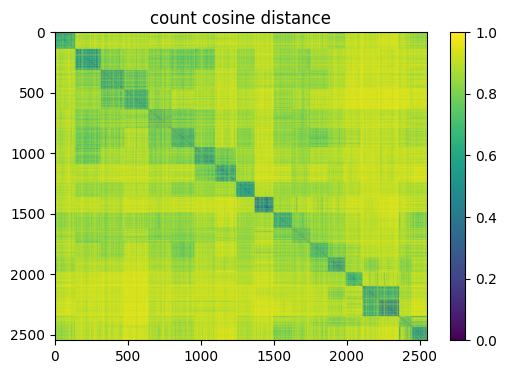

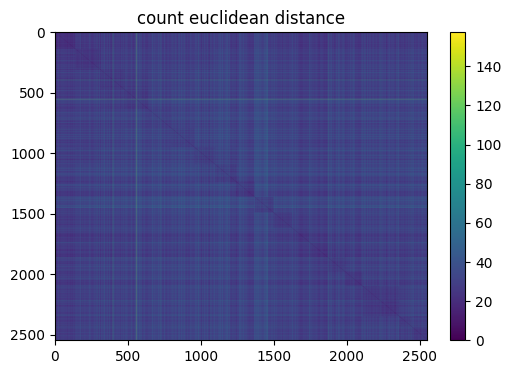


🔍 Performing PCA variance analysis for count...


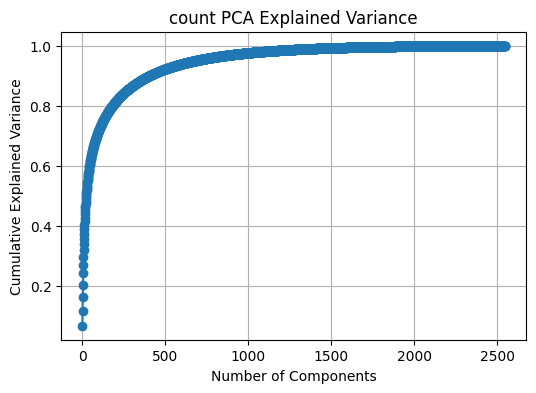

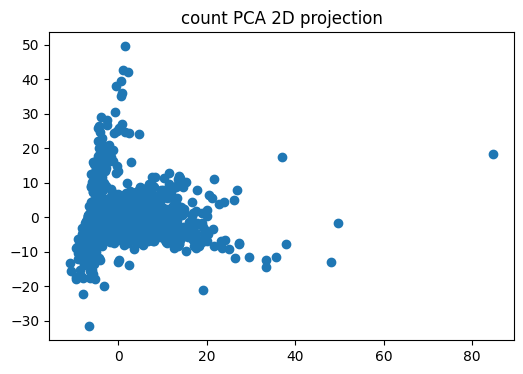

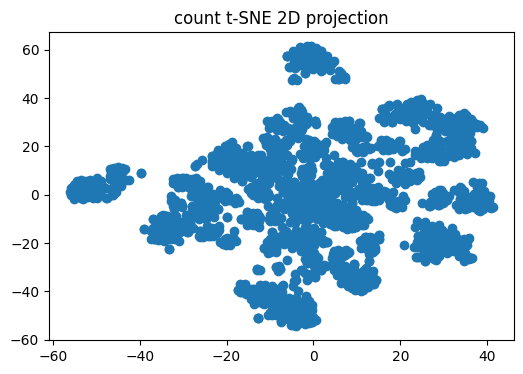


🔍 Selecting optimal cluster count for 'count' using Silhouette Score...


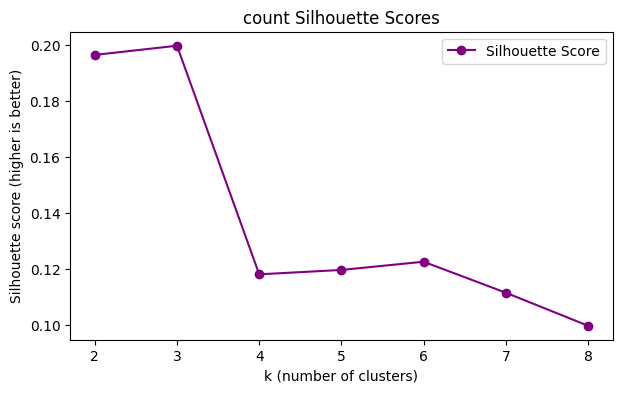

✅ Best number of clusters for count: k = 3

📈 Cluster size summary for count:
  Cluster 0: 1966 documents
  Cluster 1: 503 documents
  Cluster 2: 79 documents


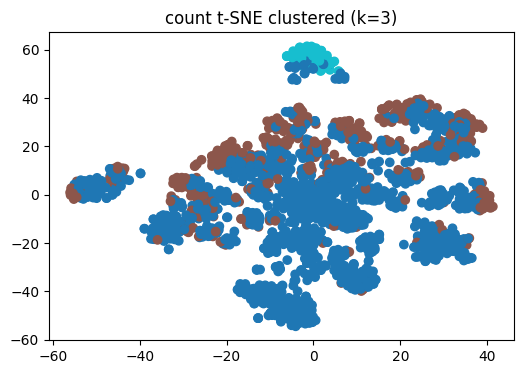


📊 Thematic Cluster Table (COUNT):
 Cluster                                                                       Top Keywords                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

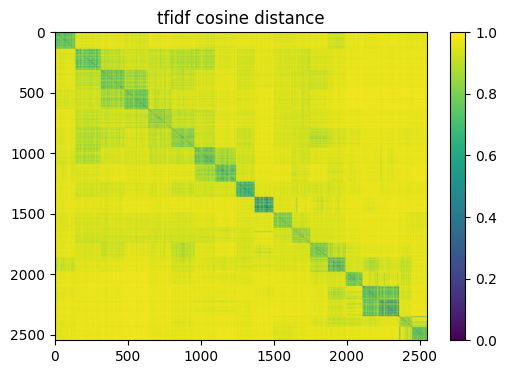

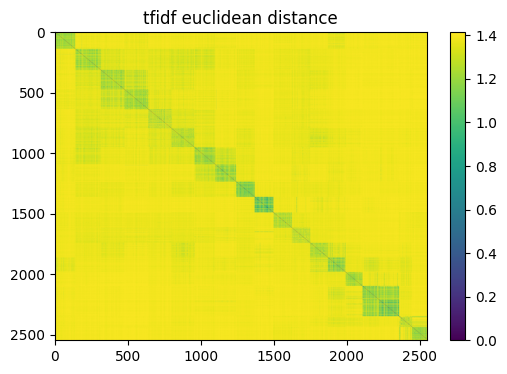


🔍 Performing PCA variance analysis for tfidf...


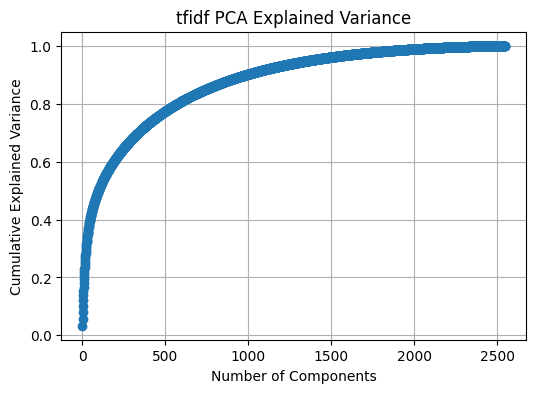

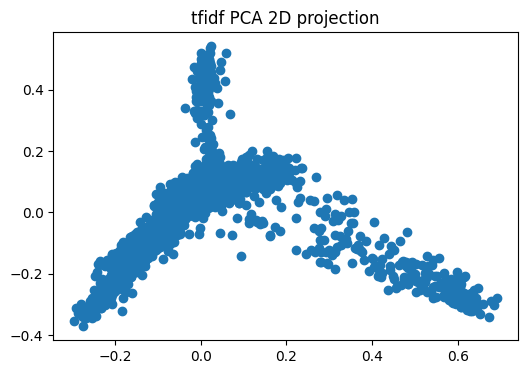

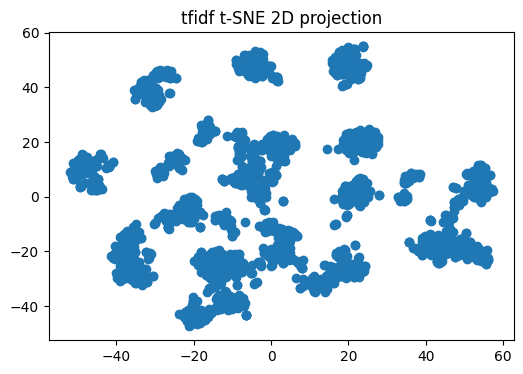


🔍 Selecting optimal cluster count for 'tfidf' using Silhouette Score...


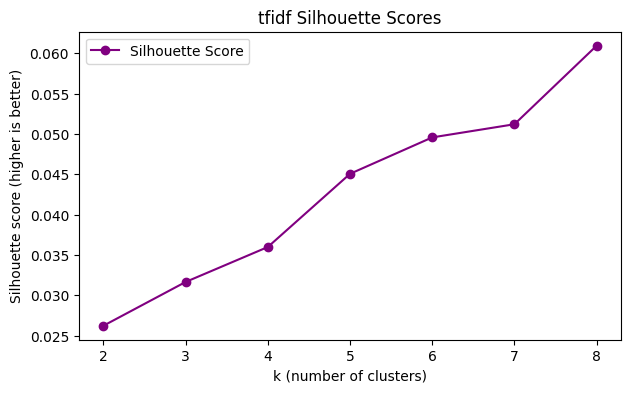

✅ Best number of clusters for tfidf: k = 8

📈 Cluster size summary for tfidf:
  Cluster 0: 442 documents
  Cluster 1: 197 documents
  Cluster 2: 594 documents
  Cluster 3: 494 documents
  Cluster 4: 357 documents
  Cluster 5: 113 documents
  Cluster 6: 226 documents
  Cluster 7: 125 documents


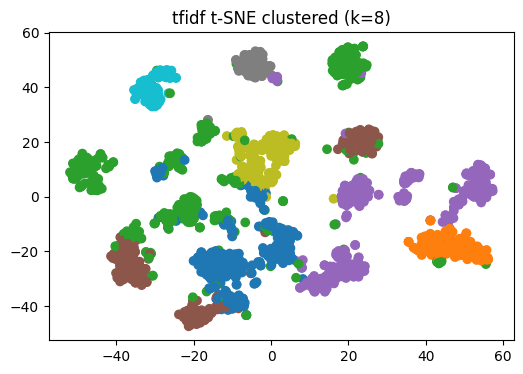


📊 Thematic Cluster Table (TFIDF):
 Cluster                                                                                     Top Keywords                                                                                                                                                              Example Topics
       0                error, model, regression, square, linear, function, data, polynomial, line, value types of arithmetic and statistical operation which can be performed on the basis of data type and a intro to linear regression, Descriptive analysis of Linear Regressions
       1                        word, vector, document, idf, text, context, tf, cbow, frequency, word2vec                                                                                                                      Embeddings encoding, Natural Language Processing (NLP)
       2                       data, value, model, table, sql, normal, miss, test, database, distribution                          

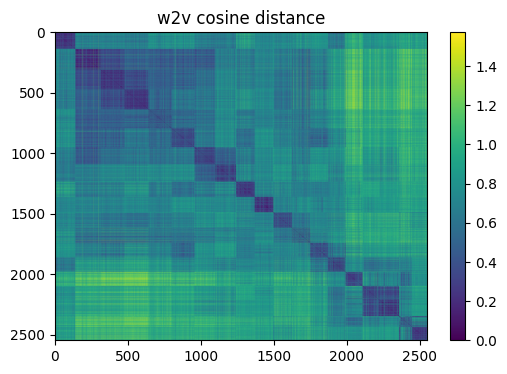

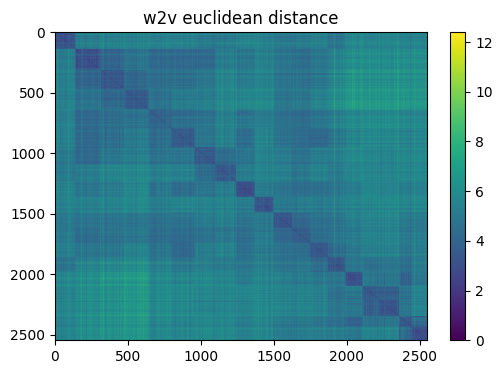


🔍 Performing PCA variance analysis for w2v...


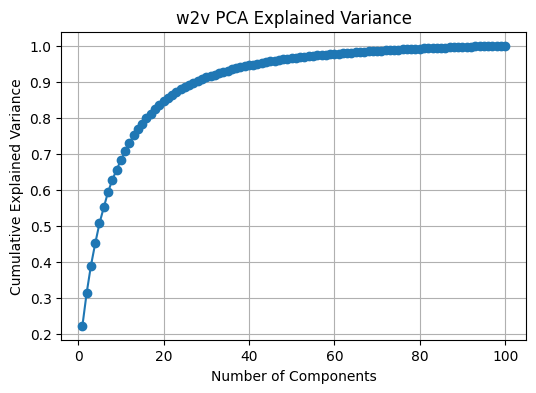

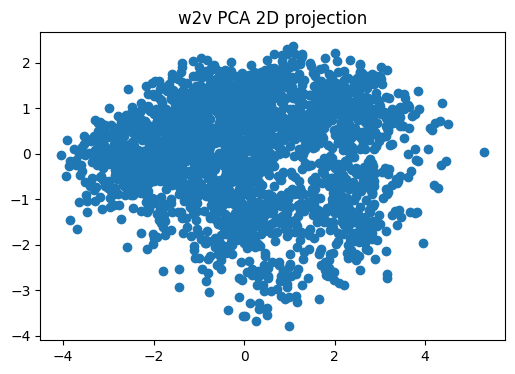

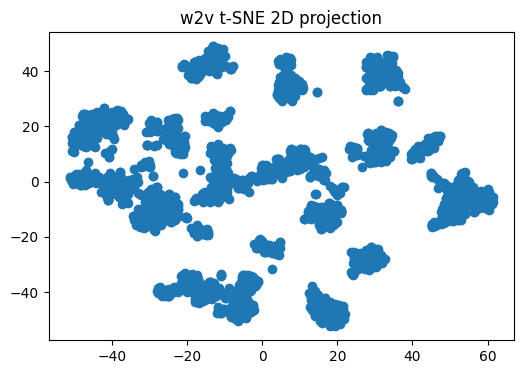


🔍 Selecting optimal cluster count for 'w2v' using Silhouette Score...


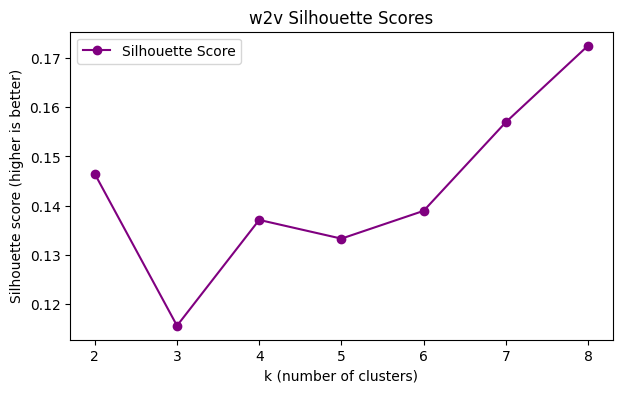

✅ Best number of clusters for w2v: k = 8

📈 Cluster size summary for w2v:
  Cluster 0: 391 documents
  Cluster 1: 233 documents
  Cluster 2: 402 documents
  Cluster 3: 213 documents
  Cluster 4: 131 documents
  Cluster 5: 137 documents
  Cluster 6: 669 documents
  Cluster 7: 372 documents


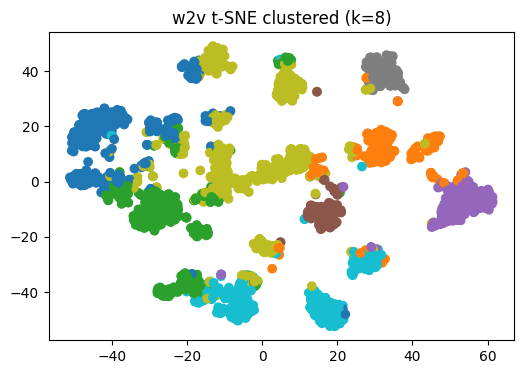


🔎 Example search for 'machine learning clustering session':
                                                  Topic  \
1415        Kmeans Clustering and Hysterical Clustering   
1484                                         clustering   
1436  Various metrics associated with clustering, DB...   
1432                              Methods of clustering   
1472     k means clustering and hierarchical clustering   

                                           YourAnalysis  \
1415  Kmeans clustering is a classification algorith...   
1484  Clustering is an unsupervised machine learning...   
1436  1) In clustering, unlike supervised learning, ...   
1432   Silhouette score and other metrics for unsupe...   
1472  K-means clustering and hierarchical clustering...   

                                      preprocessed_text     score  
1415  kmeans cluster hysterical clustering kmeans cl...  0.384421  
1484  cluster cluster unsupervised machine learning ...  0.379742  
1436  various metric asso

In [13]:

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- NLTK setup ---
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from sklearn.cluster import KMeans

# --- Ensure NLTK resources ---
nltk_data_dir = r"C:\Users\VICTUS\AppData\Roaming\nltk_data"
nltk.data.path.append(nltk_data_dir)

for pkg in ["stopwords", "punkt", "averaged_perceptron_tagger", "wordnet", "omw-1.4"]:
    try:
        nltk.download(pkg, download_dir=nltk_data_dir, quiet=True)
    except Exception as e:
        print(f"Could not download {pkg}: {e}")

# --- Global resources ---
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    """Map POS tag to WordNet POS for lemmatization"""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def preprocess_text(text):
    """Clean, tokenize, remove stopwords, and lemmatize text."""
    if pd.isna(text):
        return ""
    text = re.sub(r"[^A-Za-z0-9\s']", " ", str(text))
    text = re.sub(r"\s+", " ", text).strip().lower()
    tokens = [t for t in word_tokenize(text) if t not in stop_words and len(t) > 1]
    pos_tags = pos_tag(tokens)
    lemmas = [lemmatizer.lemmatize(t, get_wordnet_pos(p)) for t, p in pos_tags]
    return " ".join(lemmas)

# --- Machine Learning setup ---
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Try gensim Word2Vec
use_gensim = True
try:
    from gensim.models import Word2Vec
except Exception as e:
    print("⚠️ gensim unavailable; falling back to LSA embeddings.")
    use_gensim = False

# --- Configuration ---
CSV_FILE = "Session-Summary-all-2025-S1.csv"

# --- 1. Load data ---
if not Path(CSV_FILE).exists():
    raise FileNotFoundError(f"CSV file '{CSV_FILE}' not found in working directory.")

try:
    df = pd.read_csv(CSV_FILE)
except UnicodeDecodeError:
    df = pd.read_csv(CSV_FILE, encoding='latin1')
print(f"Loaded CSV shape: {df.shape}")

# Ensure required columns
for col in ["Topic", "YourAnalysis"]:
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found. Found: {list(df.columns)}")

# --- 2. Text Preprocessing ---
df["raw_text"] = df["Topic"].fillna("") + " " + df["YourAnalysis"].fillna("")
df["preprocessed_text"] = df["raw_text"].apply(preprocess_text)
df["doc_length_tokens"] = df["preprocessed_text"].apply(lambda x: len(x.split()))

# ✅ Print final preprocessed text before vectorization
print("\n🧾 --- SAMPLE OF PREPROCESSED TEXT ---")
print(df[["Topic", "YourAnalysis", "preprocessed_text"]].head().to_string(index=False))
print("✅ Text preprocessing complete.\n")

# --- 3. Vectorization ---
count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()
X_count = count_vectorizer.fit_transform(df["preprocessed_text"])
X_tfidf = tfidf_vectorizer.fit_transform(df["preprocessed_text"])

# Word2Vec or fallback
tokenized = [doc.split() for doc in df["preprocessed_text"]]
if use_gensim:
    w2v_model = Word2Vec(sentences=tokenized, vector_size=100, window=5, min_count=1, workers=4, epochs=30)
    def doc_vec(tokens):
        vecs = [w2v_model.wv[t] for t in tokens if t in w2v_model.wv]
        return np.mean(vecs, axis=0) if vecs else np.zeros(w2v_model.vector_size)
    X_w2v = np.vstack([doc_vec(toks) for toks in tokenized])
else:
    svd = TruncatedSVD(n_components=100, random_state=42)
    X_w2v = svd.fit_transform(X_tfidf)

df.to_excel("Session-Summary-all-2025-S1-processed.xlsx", index=False)
print("✅ Saved processed dataframe with vectorized text to Excel file.")

# --- 4. Silhouette-Based Clustering + Visualization ---
def analyze_vectors(X, name):
    """Analyze, visualize, and cluster given vector matrix using Silhouette-based method."""
    out = {}
    X_arr = X.toarray() if hasattr(X, "toarray") else np.array(X)

    # --- Distance heatmaps ---
    cos_dist = cosine_distances(X_arr)
    euc_dist = euclidean_distances(X_arr)

    plt.figure(figsize=(6,4))
    plt.imshow(cos_dist, aspect='auto')
    plt.title(name + " cosine distance")
    plt.colorbar(); plt.show()

    plt.figure(figsize=(6,4))
    plt.imshow(euc_dist, aspect='auto')
    plt.title(name + " euclidean distance")
    plt.colorbar(); plt.show()

    # --- PCA variance analysis ---
    print(f"\n🔍 Performing PCA variance analysis for {name}...")
    pca_full = PCA().fit(X_arr)
    explained_variance = np.cumsum(pca_full.explained_variance_ratio_)

    plt.figure(figsize=(6,4))
    plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
    plt.title(f"{name} PCA Explained Variance")
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.grid(True)
    plt.show()

    # --- PCA 2D visualization ---
    pca = PCA(n_components=2, random_state=42)
    pca_coords = pca.fit_transform(X_arr)
    out["pca_coords"] = pca_coords
    plt.figure(figsize=(6,4))
    plt.scatter(pca_coords[:,0], pca_coords[:,1])
    plt.title(name + " PCA 2D projection")
    plt.show()

    # --- t-SNE visualization ---
    tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
    tsne_coords = tsne.fit_transform(X_arr)
    out["tsne_coords"] = tsne_coords
    plt.figure(figsize=(6,4))
    plt.scatter(tsne_coords[:,0], tsne_coords[:,1])
    plt.title(name + " t-SNE 2D projection")
    plt.show()

    # --- Silhouette-based clustering ---
    print(f"\n🔍 Selecting optimal cluster count for '{name}' using Silhouette Score...")
    sil_scores = {}
    for k in range(2, min(9, len(X_arr))):
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(X_arr)
        try:
            sil = silhouette_score(X_arr, labels)
        except Exception:
            sil = -1
        sil_scores[k] = sil

    # Plot silhouette scores
    plt.figure(figsize=(7,4))
    plt.plot(list(sil_scores.keys()), list(sil_scores.values()), 'o-', color='purple', label='Silhouette Score')
    plt.title(f"{name} Silhouette Scores")
    plt.xlabel("k (number of clusters)")
    plt.ylabel("Silhouette score (higher is better)")
    plt.legend(); plt.show()

    best_k = max(sil_scores, key=sil_scores.get)
    print(f"✅ Best number of clusters for {name}: k = {best_k}")

    # --- Final KMeans fit ---
    best_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    labels = best_kmeans.fit_predict(X_arr)
    out["best_k"] = best_k
    out["kmeans_labels"] = labels

    # --- Cluster Analysis Summary ---
    cluster_sizes = pd.Series(labels).value_counts().sort_index()
    print(f"\n📈 Cluster size summary for {name}:")
    for k, size in cluster_sizes.items():
        print(f"  Cluster {k}: {size} documents")

    # Assign cluster labels back to dataframe for later use
    df[f"{name}_cluster"] = labels

    # --- Clustered t-SNE plot ---
    plt.figure(figsize=(6,4))
    plt.scatter(tsne_coords[:,0], tsne_coords[:,1], c=labels, cmap='tab10')
    plt.title(f"{name} t-SNE clustered (k={best_k})")
    plt.show()

    # --- Thematic Table for Count/TFIDF ---
    if name.lower() in ["count", "tfidf"]:
        vocab = (count_vectorizer.get_feature_names_out()
                 if name.lower()=="count" else tfidf_vectorizer.get_feature_names_out())
        cluster_terms = {}
        cluster_examples = {}

        for k in range(best_k):
            idx = np.where(labels == k)[0]
            if len(idx)==0:
                cluster_terms[k] = []
                cluster_examples[k] = []
                continue
            centroid = X_arr[idx].mean(axis=0)
            topn = centroid.argsort()[::-1][:10]
            cluster_terms[k] = [vocab[i] for i in topn]
            cluster_examples[k] = df.iloc[idx]["Topic"].head(2).tolist()  # 2 example topics per cluster

        cluster_table = pd.DataFrame({
            "Cluster": list(cluster_terms.keys()),
            "Top Keywords": [", ".join(v) for v in cluster_terms.values()],
            "Example Topics": [", ".join(v) for v in cluster_examples.values()]
        })

        print(f"\n📊 Thematic Cluster Table ({name.upper()}):")
        print(cluster_table.to_string(index=False))
        out["cluster_table"] = cluster_table

    return out

# --- Run analyses ---
res_count = analyze_vectors(X_count, "count")
res_tfidf = analyze_vectors(X_tfidf, "tfidf")
res_w2v = analyze_vectors(X_w2v, "w2v" if use_gensim else "w2v_lsa")

# --- Example TF-IDF search function ---
def search_documents(query, topn=5):
    """Find top similar documents to a query using TF-IDF cosine similarity."""
    pre = preprocess_text(query)
    q_tfidf = tfidf_vectorizer.transform([pre])
    sims = (1 - cosine_distances(q_tfidf, X_tfidf)).ravel()
    top_idx = sims.argsort()[::-1][:topn]
    return df.iloc[top_idx][["Topic", "YourAnalysis", "preprocessed_text"]].assign(score=sims[top_idx])

print("\n🔎 Example search for 'machine learning clustering session':")
print(search_documents("machine learning clustering session", topn=5))

print("\n✅ Analysis complete — all plots displayed interactively.")



📊 Thematic Cluster Table (Problem 3 - Word2Vec + TF-IDF)
 Cluster                                                                            Top Keywords (TF-IDF)                                                                                                                                                Example Topics / Submissions
       0                error, model, regression, square, linear, function, data, polynomial, line, value types of arithmetic and statistical operation which can be performed on the basis of data type and a intro to linear regression, Descriptive analysis of Linear Regressions
       1                        word, vector, document, idf, text, context, tf, cbow, frequency, word2vec                                                                  Why does Normal distribution show up in nature?, Analzing error distributions to evaluate model performace
       2                       data, value, model, table, sql, normal, miss, test, database, distribution   

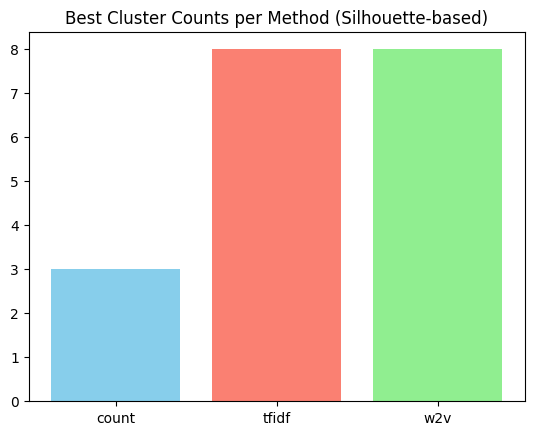

In [12]:
# --- Problem 2: Thematic Cluster Table (Word2Vec + TF-IDF keywords) ---

def generate_thematic_table(df, clustering_res, tfidf_res):
    """
    Generate a table summarizing thematic clusters:
    - Cluster number
    - Top keywords (from TF-IDF)
    - Example topics/submissions
    """
    cluster_table = []

    best_k = clustering_res["best_k"]
    labels = clustering_res["kmeans_labels"]

    for k in range(best_k):
        idx = np.where(labels == k)[0]

        # Top TF-IDF terms for this cluster
        if "cluster_table" in tfidf_res:
            top_keywords = tfidf_res["cluster_table"].iloc[k]["Top Keywords"]
        else:
            top_keywords = "N/A"

        # Example topics (first 2 submissions in this cluster)
        example_topics = df.iloc[idx]["Topic"].head(2).tolist()
        cluster_table.append({
            "Cluster": k,
            "Top Keywords (TF-IDF)": top_keywords,
            "Example Topics / Submissions": ", ".join(example_topics)
        })

    cluster_df = pd.DataFrame(cluster_table)
    return cluster_df

# --- Generate the table ---
thematic_table = generate_thematic_table(df, res_w2v, res_tfidf)

# --- Display and optionally save to Excel ---
print("\n📊 Thematic Cluster Table (Problem 3 - Word2Vec + TF-IDF)")
print(thematic_table.to_string(index=False))

# Save table to Excel if needed
thematic_table.to_excel("Thematic_Clusters_Problem3.xlsx", index=False)

methods = ["count", "tfidf", "w2v"]
scores = [max(res_count['best_k'], 0), max(res_tfidf['best_k'], 0), max(res_w2v['best_k'], 0)]
plt.bar(methods, scores, color=['skyblue','salmon','lightgreen'])
plt.title("Best Cluster Counts per Method (Silhouette-based)")
plt.show()
